# Labels for all 

Now that we have identified some famous paintings, we also want to know what the other illustrations are about. We use the AI Vision tool from Google Cloud Platform. For that, you need to setup correctly your [Google Vision AI](https://cloud.google.com/vision?hl=fr) account.

In [1]:
# Some import
import io
import os
import glob
import pandas as pd
# Imports the Google Cloud client library
from google.cloud import vision
from tqdm import tqdm
from IPython.display import Image
from collections import OrderedDict
import math
import json
import shutil
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Get all labels

First, for all the illustration that we have, we submit them to the Vision AI tool from Google, to output labels for each images. The labels are words describing the image, and an associatied probability.

In [33]:
all_illus = glob.glob("./not_known_paintings/*.jpg")

In [34]:
# Instantiates a client
client = vision.ImageAnnotatorClient()
data = []
for illu in tqdm(all_illus):
    # The name of the image file to annotate
    file_name = os.path.abspath(illu)

    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations
    label_dict = {}
    for label in labels:
        label_dict[label.description] = label.score

    data.append({'id': file_name.split('/')[-1].split('.')[0], 'labels': label_dict})

100%|██████████| 8939/8939 [45:23<00:00,  3.28it/s]  


And saving the labels

In [35]:
pd.DataFrame(data).to_csv('labels_illus.csv', index = False)

## Clean labels

We now have too many different labels and categories in each image. We will want to put each image into one of the seven categories : Sculpture, Reproduction, Object, Ornament, Plan, Architecture/Decoration, and Photography. To achieve that, we will first manually classify some of the images, count the labels that fall into each category. That will create a distribution of labels depending on the category. We will create a Bayes classifier based on it to classify the remaining illustrations. 

In [ ]:
# Load the data
df = pd.read_csv('labels_illus.csv').drop(columns=['Unnamed: 0'])

In [188]:
# Some small cleaning
df['labels'] = df.apply(lambda row: json.loads(row['labels'].replace("\'",  "\"").replace("Devil\"s bridge", "Devil's bridge")), axis=1)

Let's look at one example of the output from Google Vision AI.

ILLU_11508_28_1
dict_keys(['Forehead', 'Nose', 'Cheek', 'Head', 'Chin', 'Hairstyle', 'Eyebrow', 'Sculpture', 'Statue', 'Jaw'])


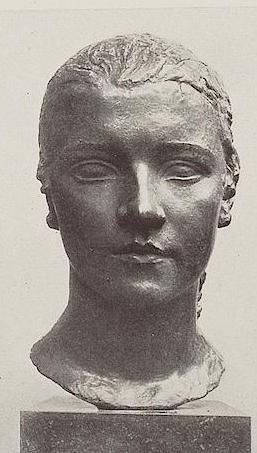

In [381]:
sample = df.sample()
print(sample['id'].iloc[0])
kws = dict(sample['labels'].iloc[0]).keys()
print(kws)
Image(filename='./not_known_paintings/' + sample['id'].iloc[0] + '.jpg') 

We manually classify some of the illustration by repeateadly call `add_object` and adding random illustrations and their category.

In [294]:
categories = OrderedDict({'Sculpture': 0, 'Reproduction': 0, 'Object': 0, 'Ornament': 0, 'Plan' : 0, 
              'Architecture/Decoration' : 0, 'Photography' : 0})
#cat_keywords = [dict(), dict(), dict(), dict(), dict(), dict(), dict()]

In [295]:
def add_object(d_cats, d_kw, predictions, actual_class):
    #d_cats[actual_class] = d_cats.get(actual_class, 0) + 1
    for p in predictions:
        d_kw[list(d_cats).index(actual_class)][p] = d_kw[list(d_cats).index(actual_class)].get(p, 0) + 1

In [382]:
add_object(categories, cat_keywords, kws, 'Sculpture')

In [2]:
cat_keywords

Because the word 'Art' is in almost every illustration and does not inform us very much about the category, we discard it.

In [3]:
for d in cat_keywords:
    if 'Art' in d.keys():
        d.pop('Art') 

## Most important words
To keep only the words that give us the most information on the category it belongs to, we use the TF-IDF method, usually used on documents, where the documents are the categories and the words are the weighted keywords.

In [4]:
dataset = [' '.join([' '.join([d[0] for i in range(d[1])]) for d in dkw.items()]) for dkw in cat_keywords]
# Vectorize with TF-IDF
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(dataset)
df_tfidf = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)
# List of most important top 100 words
most_important_kw = list(df_tfidf.iloc[:100].index)

/Users/elisamichelet/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# Keep only most important top 100 words
for d in cat_keywords:
    for k in list(d.keys()):
        if str.lower(k) not in most_important_kw:
            d.pop(k) 

## Naive Bayes Classifier

We compute the values for the Bayes classifier.

The priors are the probability of the category.

The likelihood is the probability of a word to appear given the category.

The normalized category keywords are the probability of a keyword in the whole set.

In [6]:
# Prior calculation
priors = [sum(x.values()) for x in cat_keywords]
priors = [p/sum(priors) for p in priors]

In [7]:
# Smooth them, to not completely discard lower probability categories
priors_smooth = [0.25, 0.3, 0.1, 0.1, 0.05, 0.1, 0.1]

In [8]:
# Likelihood calculation
likelihood = dict()
for dkw in cat_keywords:
    likelihood = {**likelihood, **dkw}
likelihood = {k: v / total for total in (sum(likelihood.values()),) for k, v in likelihood.items()}

In [9]:
# Normalize categroy keywords
normalized_cat_kw = cat_keywords.copy()
for d in normalized_cat_kw:
    for kw in d.keys():
        d[kw] = d[kw]/sum(d.values())

In [10]:
cats = ['Sculpture', 'Reproduction', 'Object', 'Ornament', 'Plan', 
             'Architecture/Decoration', 'Photography']

We compute the classidier the following way:

$$ prediction = max_{cat} \frac{p(kw|cat) p(cat)}{p(kw)}$$

We also create a "doubt" (uncertainty) measure : no category have more than 0.4 probability, of if the first two categories are very close, or if more than two categories have more than 0.8 of probability. Those illustration swill be checked manually

In [11]:
# From the labels of the image, output the category that is the most likely
# as well as an uncertainty flag
def most_likely_category(labels, probas):
    scores = []
    for c in range(len(normalized_cat_kw)):
        # Bayes probability
        s = sum([normalized_cat_kw[c].get(kw, 0.00001) * probas[i] / likelihood.get(kw, 0.00001)  for i, kw in enumerate(labels)])/len(labels)*priors_smooth[c]
        scores.append(s)
    # Uncertainty
    doubt = max(scores) < 0.4 or len([e for e in scores if e > 0.8]) > 1 or (sorted(scores)[-1] - sorted(scores)[-2]) < 0.2
    return cats[scores.index(max(scores))], doubt

Let's look at a random sample's prediction

In [ ]:
sample = df.sample()
kws = sample['labels'].iloc[0].keys()
probas = sample['labels'].iloc[0].values()
print(kws)
print(most_likely_category(list(kws), list(probas)))
Image(filename='./not_known_paintings/' + sample['id'].iloc[0] + '.jpg') 

And compute the most likely category and their doubt or not, for all the images

In [436]:
df['pred_cat'] = df.apply(lambda row: most_likely_category(list(row['labels'].keys()), list(row['labels'].values()))[0], axis=1)

In [438]:
df['doubt'] = df.apply(lambda row: most_likely_category(list(row['labels'].keys()), list(row['labels'].values()))[1], axis=1)

In [445]:
df.groupby(['doubt', 'pred_cat']).count()

id  labels
doubt pred_cat                             
False Architecture/Decoration   336     336
      Object                      7       7
      Reproduction             2986    2986
      Sculpture                 411     411
True  Architecture/Decoration   543     543
      Object                    132     132
      Ornament                    3       3
      Reproduction             3909    3909
      Sculpture                 612     612

In [453]:
# Small renaming
df['pred_cat'] = df.apply(lambda row: 'Architecture_decoration' if row['pred_cat'] == 'Architecture/Decoration' else row['pred_cat'], axis=1)

Preparing the files to manually sort the doubting ones.

In [461]:
def copy_file(im_id, pred):
    shutil.copyfile('not_known_paintings/' + im_id + '.jpg' , pred + '/' + im_id + '.jpg')
    return True

In [466]:
# Copy the files to be manually checked into a separate folder
df_op = pd.DataFrame()
df_op['id'] = df[df['doubt']]['id']
df_op['copied'] = df[df['doubt']].apply(lambda row: copy_file(row['id'], row['pred_cat']), axis=1)

Now, we manually classified the uncertained paintings.

Then, we can run the following few cells to change the labels of the no more doubting illustrations

In [486]:
objects = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Object/*.jpg")]
sculpture = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Sculpture/*.jpg")]
archideco = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Architecture_decoration/*.jpg")]
onrament = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Ornament/*.jpg")]
photography = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Photography/*.jpg")]
plan = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Plan/*.jpg")]
repro = [n.split('/')[-1].split('.jpg')[0] for n in glob.glob("./Reproduction/*.jpg")]

And tada all our illustrations are classified into one of the 7 categories !

In [479]:
final_cats_df = df[df['doubt'] == False].drop(columns=['labels', 'doubt'])

,id,pred_cat
2,ILLU_14351_140_4,Reproduction
5,ILLU_11283_315_0,Reproduction
8,ILLU_11581_152_0,Reproduction
9,ILLU_11300_759_1,Reproduction
10,ILLU_15410_398_1,Reproduction
...,...,...
8931,ILLU_15501_8_1,Architecture_decoration
8932,ILLU_13298_67_0,Sculpture
8933,ILLU_10944_367_0,Reproduction
8934,ILLU_10953_136_1,Sculpture


In [482]:
def add_category_to_df(cat_name, illu_list, df):
    return df.append(pd.DataFrame([{'id' : illu, 'pred_cat' : cat_name} for illu in illu_list]))

In [487]:
# Add them to the dataframe
final_cats_df = df[df['doubt'] == False].drop(columns=['labels', 'doubt'])
final_cats_df = add_category_to_df('Sculpture', sculpture, final_cats_df)
final_cats_df = add_category_to_df('Architecture_decoration', archideco, final_cats_df)
final_cats_df = add_category_to_df('Ornament', onrament, final_cats_df)
final_cats_df = add_category_to_df('Photography', photography, final_cats_df)
final_cats_df = add_category_to_df('Object', objects, final_cats_df)
final_cats_df = add_category_to_df('Plan', plan, final_cats_df)
final_cats_df = add_category_to_df('Reproduction', repro, final_cats_df)
final_cats_df

,id,pred_cat
2,ILLU_14351_140_4,Reproduction
5,ILLU_11283_315_0,Reproduction
8,ILLU_11581_152_0,Reproduction
9,ILLU_11300_759_1,Reproduction
10,ILLU_15410_398_1,Reproduction
...,...,...
3354,ILLU_10558_110_0,Reproduction
3355,ILLU_10575_169129_0,Reproduction
3356,ILLU_11353_257_3,Reproduction
3357,ILLU_14941_159_0,Reproduction


And we save the data !

In [489]:
final_cats_df.to_csv('final_pred_cat.csv', index=False)